In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
from scipy import ndimage

import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.modeling import models, fitting, Fittable2DModel, Parameter
from ccdproc import CCDData, combine, Combiner, flat_correct, trim_image

In [2]:
class mosfireAlignmentBox(Fittable2DModel):
    amplitude = Parameter(default=1)
    x_0 = Parameter(default=0)
    y_0 = Parameter(default=0)
    x_width = Parameter(default=1)
    y_width = Parameter(default=1)

    @staticmethod
    def evaluate(x, y, amplitude, x_0, y_0, x_width, y_width):
        '''MOSFIRE Alignment Box.
        
        Typical widths are 22.5 pix horizontally and 36.0 pix vertically.
        
        Angle of slit relative to pixels is 3.78 degrees.
        '''
        slit_angle = -3.7 # in degrees
        x0_of_y = x_0 + (y-y_0)*np.sin(slit_angle*np.pi/180)
        
        x_range = np.logical_and(x >= x0_of_y - x_width / 2.,
                                 x <= x0_of_y + x_width / 2.)
        y_range = np.logical_and(y >= y_0 - y_width / 2.,
                                 y <= y_0 + y_width / 2.)
        result = np.select([np.logical_and(x_range, y_range)], [amplitude], 0)

        if isinstance(amplitude, u.Quantity):
            return Quantity(result, unit=amplitude.unit, copy=False)
        else:
            return result

    @property
    def bounding_box(self):
        """
        Tuple defining the default ``bounding_box``.

        ``((y_low, y_high), (x_low, x_high))``
        """

        dx = self.x_width / 2
        dy = self.y_width / 2

        return ((self.y_0 - dy, self.y_0 + dy),
                (self.x_0 - dx, self.x_0 + dx))

    @property
    def input_units(self):
        if self.x_0.unit is None:
            return None
        else:
            return {'x': self.x_0.unit,
                    'y': self.y_0.unit}

    def _parameter_units_for_data_units(self, inputs_unit, outputs_unit):
        return OrderedDict([('x_0', inputs_unit['x']),
                            ('y_0', inputs_unit['y']),
                            ('x_width', inputs_unit['x']),
                            ('y_width', inputs_unit['y']),
                            ('amplitude', outputs_unit['z'])])

In [3]:
def fit_edges(profile):
    fitter = fitting.LevMarLSQFitter()

    amp1_est = profile[profile == min(profile)][0]
    mean1_est = np.argmin(profile)
    amp2_est = profile[profile == max(profile)][0]
    mean2_est = np.argmax(profile)
    
    g_init1 = models.Gaussian1D(amplitude=amp1_est, mean=mean1_est, stddev=2.)
    g_init1.amplitude.max = 0
    g_init1.amplitude.min = amp1_est*0.9
    g_init1.stddev.max = 3
    g_init2 = models.Gaussian1D(amplitude=amp2_est, mean=mean2_est, stddev=2.)
    g_init2.amplitude.min = 0
    g_init2.amplitude.min = amp2_est*0.9
    g_init2.stddev.max = 3


    model = g_init1 + g_init2
    fit = fitter(model, range(0,horizontal_profile.shape[0]), horizontal_profile)
    
    # Check Validity of Fit
    if abs(fit.stddev_0.value) <= 3 and abs(fit.stddev_1.value) <= 3\
       and fit.amplitude_0.value < -1 and fit.amplitude_1.value > 1\
       and fit.mean_0.value > fit.mean_1.value:
        x1 = fit.mean_0.value
        x2 = fit.mean_1.value
    else:
        x1 = None
        x2 = None

    return x1, x2

## Create Flat Field

In [4]:
filepath = '../../KeckData/MOSFIRE_FCS/'
dark = CCDData.read(os.path.join(filepath, 'm180130_0001.fits'), unit='adu')

flatfiles = ['m180130_0320.fits',
         'm180130_0321.fits',
         'm180130_0322.fits',
         'm180130_0323.fits',
         'm180130_0324.fits',
        ]
flats = []
for i,file in enumerate(flatfiles):
    flat = CCDData.read(os.path.join(filepath, file), unit='adu')
    flat = flat.subtract(dark)
    flats.append(flat)

INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]


In [5]:
flat_combiner = Combiner(flats)
flat_combiner.sigma_clipping()
scaling_func = lambda arr: 1/np.ma.average(arr)
flat_combiner.scaling = scaling_func
masterflat = flat_combiner.median_combine()

# masterflat.write('masterflat.fits', overwrite=True)

## Process Alignment Image

In [6]:
align1 = CCDData.read(os.path.join(filepath, 'm180130_0052.fits'), unit='adu')
# align2 = CCDData.read(os.path.join(filepath, 'm180130_0051.fits'), unit='adu')

INFO: using the unit adu passed to the FITS reader instead of the unit ADU per coadd in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [7]:
align1ds = align1.subtract(dark)
# align2ds = align2.subtract(dark)
align1f = flat_correct(align1ds, masterflat)
# align2f = flat_correct(align2ds, masterflat)

/Users/jwalawender/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)
/Users/jwalawender/anaconda/lib/python3.6/site-packages/astropy/nddata/nduncertainty.py:606: RuntimeWarning: divide by zero encountered in true_divide
  right = (other_uncert.array / other_uncert.parent_nddata.data)


In [8]:
# align1f.write('alignment_image1.fits', overwrite=True)
# align2f.write('alignment_image2.fits', overwrite=True)

## Find Alignment Box and Star

[1227:1287, 402:462]


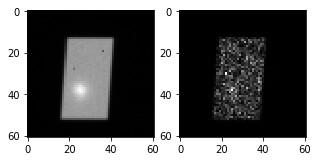

In [9]:
box_loc = (1257, 432)
box_size = 30
fits_section = f'[{box_loc[0]-box_size:d}:{box_loc[0]+box_size:d}, {box_loc[1]-box_size:d}:{box_loc[1]+box_size:d}]'
print(fits_section)
region = trim_image(align1f, fits_section=fits_section)

plt.figure(figsize=(5,10))
plt.subplot(1,2,1)
plt.imshow(region.data)
plt.subplot(1,2,2)
plt.imshow(region.uncertainty.array)

In [10]:
threshold_pct = 70
window = region.data > np.percentile(region.data, threshold_pct)
alignment_box_position = ndimage.measurements.center_of_mass(window)
# plt.imshow(window)

In [11]:
gradx = np.gradient(region.data, axis=1)
horizontal_profile = np.sum(gradx, axis=0)
grady = np.gradient(region.data, axis=0)
vertical_profile = np.sum(grady, axis=1)

In [12]:
# plt.plot(horizontal_profile)
h_edges = fit_edges(horizontal_profile)
print(h_edges)
print(h_edges[0]-h_edges[1])

(39.790421547279379, 17.340539682653407)
22.4498818646


In [13]:
# plt.plot(vertical_profile)
v_edges = fit_edges(vertical_profile)
print(v_edges)
print(v_edges[0]-v_edges[1])

(53.47503558627843, 17.453436659695061)
36.0215989266


In [14]:
boxamplitude = np.percentile(region.data, 90)
star_amplitude = region.data.max() - boxamplitude

box = mosfireAlignmentBox(boxamplitude, alignment_box_position[1], alignment_box_position[0],\
                   abs(h_edges[0]-h_edges[1]), abs(v_edges[0]-v_edges[1]))

star = models.Gaussian2D(star_amplitude, 22, 38)
star.amplitude.min = 0
star.x_stddev.min = 1
star.x_stddev.max = 8
star.y_stddev.min = 1
star.y_stddev.max = 8

model = box + star
print(star_amplitude, alignment_box_position[1], alignment_box_position[0])

5022.85516155 28.605734767 32.5994623656


In [15]:
fitter = fitting.LevMarLSQFitter()
y, x = np.mgrid[:2*box_size+1, :2*box_size+1]
fit = fitter(model, x, y, region.data)

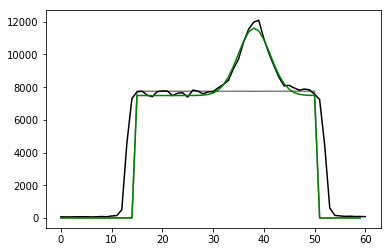

In [16]:
plt.plot(region.data[:,26], 'k-')
plt.plot([model(26, i) for i in range(0,60)], 'k-', alpha=0.5)
plt.plot([fit(26, i) for i in range(0,60)], 'g-')

In [17]:
modelim = np.zeros((61,61))
fitim = np.zeros((61,61))
for i in range(0,60):
    for j in range(0,60):
        modelim[j,i] = model(i,j)
        fitim[j,i] = fit(i,j)
resid = region.data-fitim

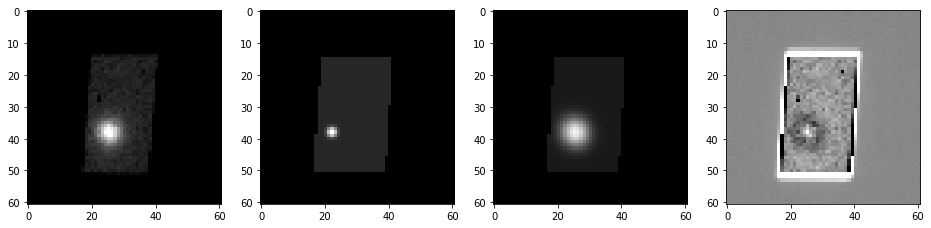

In [18]:
plt.figure(figsize=(16,24))
plt.subplot(1,4,1)
plt.imshow(region.data, vmin=7000, vmax=12000)
plt.subplot(1,4,2)
plt.imshow(modelim, vmin=7000, vmax=12000)
plt.subplot(1,4,3)
plt.imshow(fitim, vmin=7000, vmax=12000)
plt.subplot(1,4,4)
plt.imshow(resid, vmin=-1000, vmax=1000)

In [19]:
pixelscale = u.pixel_scale(0.1798*u.arcsec/u.pixel)
FWHMx = 2*(2*np.log(2))**0.5*fit.x_stddev_1 * u.pix
FWHMy = 2*(2*np.log(2))**0.5*fit.y_stddev_1 * u.pix
FWHM = (FWHMx**2 + FWHMy**2)**0.5/2**0.5
stellar_flux = 2*np.pi*fit.amplitude_1.value*fit.x_stddev_1.value*fit.y_stddev_1.value

print(f"Stellar FWHM = {FWHM.to(u.arcsec, equivalencies=pixelscale):.2f}")
print(f"Stellar Xpos = {fit.x_mean_1.value:.1f}")
print(f"Stellar Xpos = {fit.y_mean_1.value:.1f}")
print(f"Box X Center = {fit.x_0_0.value:.1f}")
print(f"Box Y Center = {fit.y_0_0.value:.1f}")
print(f"Sky Brightness = {fit.amplitude_0.value:.0f} ADU")
print(f"Stellar Amplitude = {fit.amplitude_1.value:.0f} ADU")
print(f"Stellar Flux (fit) = {stellar_flux:.0f} ADU")

Stellar FWHM = 1.31 arcsec
Stellar Xpos = 25.2
Stellar Xpos = 38.0
Box X Center = 28.6
Box Y Center = 32.6
Sky Brightness = 7488 ADU
Stellar Amplitude = 4272 ADU
Stellar Flux (fit) = 256190 ADU


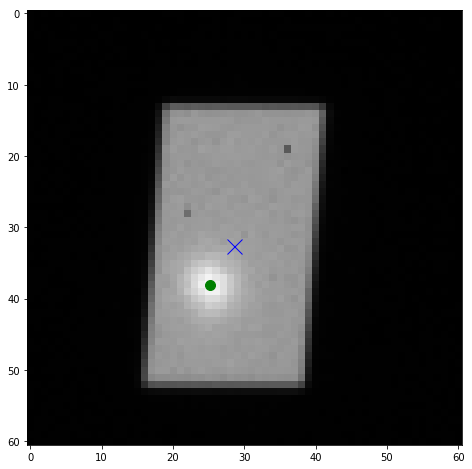

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(region.data)
plt.plot([fit.x_mean_1.value], [fit.y_mean_1.value], 'go', ms=10)
plt.plot([fit.x_0_0.value], [fit.y_0_0.value], 'bx', ms=15)